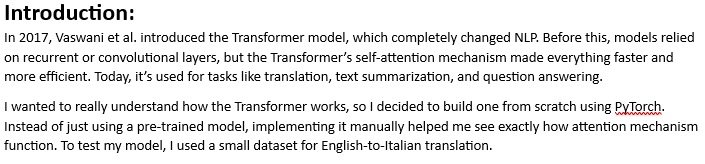

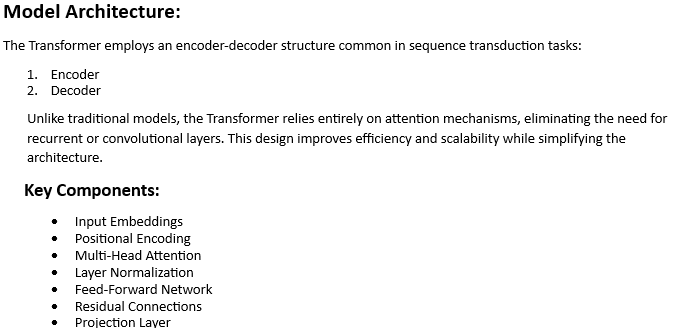

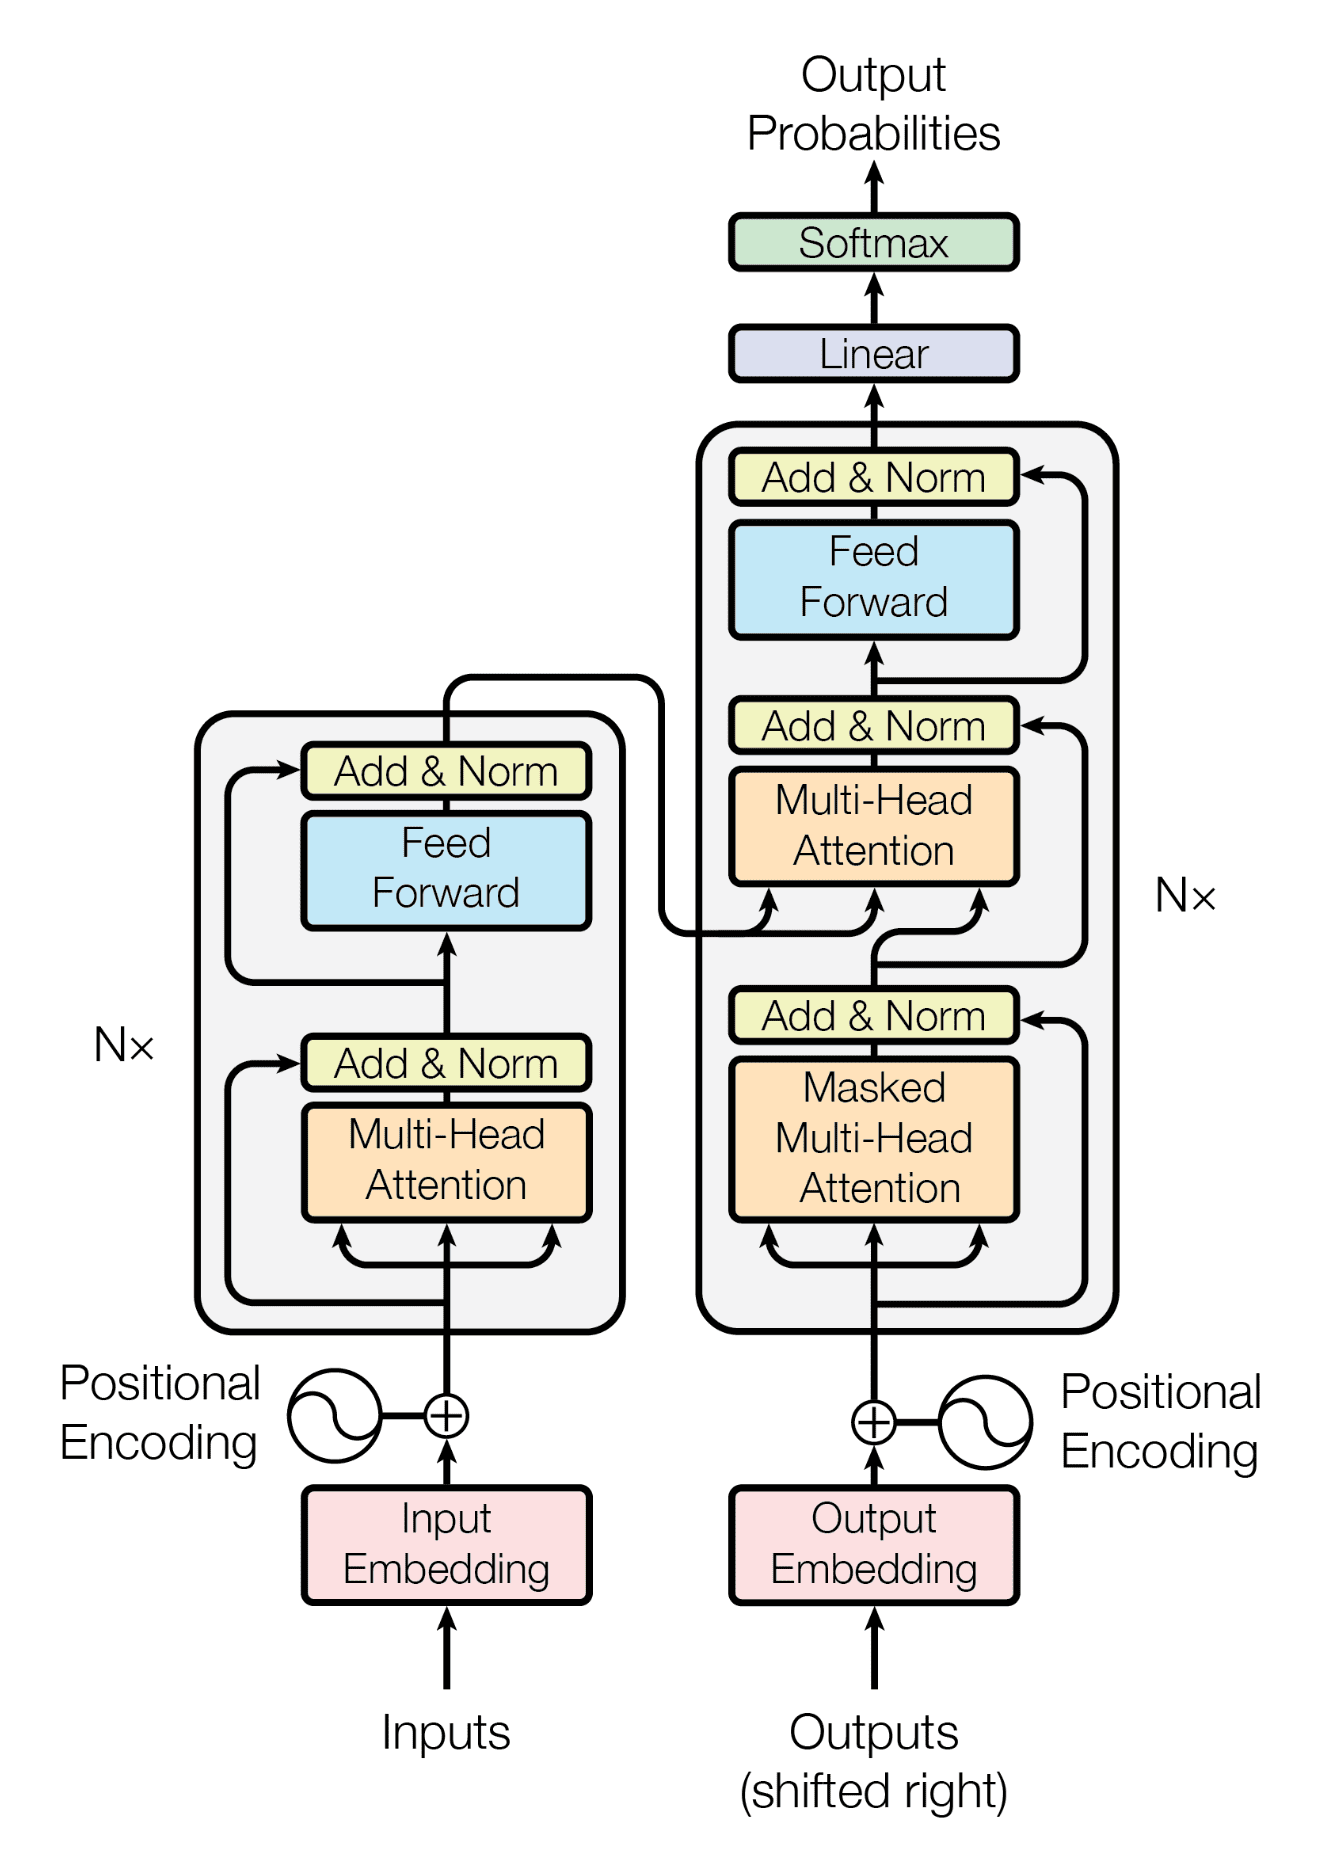

In [33]:
!pip install datasets

In [34]:
# all the important liberires from pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter


In [35]:
import math

In [36]:
#HuggingFace libraries
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace

In [37]:
#pathlib
from pathlib import Path

In [38]:
#typing
from typing import Any

#Library for progress bars in loops
from tqdm import tqdm

#importing library of warnings
import warnings


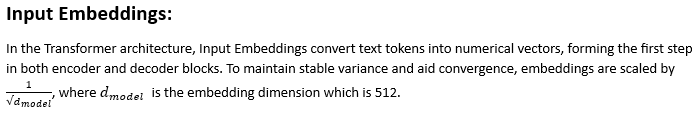

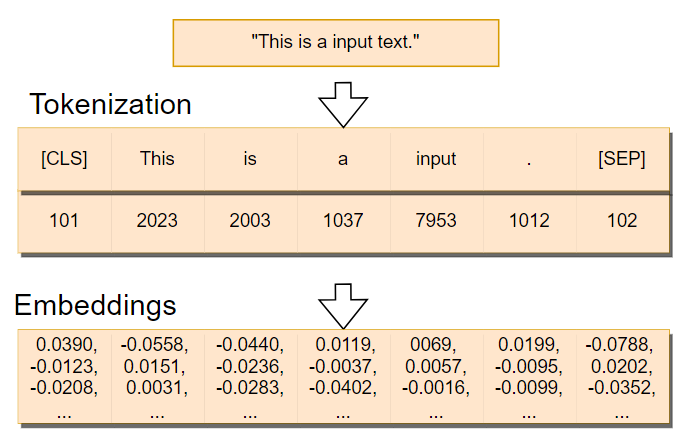

In [39]:
# Creating Input Embeddings
class InputEmbeddings(nn.Module):

    def __init__(self, d_model: int, vocab_size: int):
        super().__init__()
        # Dimension of vectors (512)
        self.d_model = d_model
        # Size of the vocabulary
        self.vocab_size = vocab_size
        # PyTorch layer that converts integer indices to dense embeddings
        self.embedding = nn.Embedding(vocab_size, d_model)

    def forward(self, x):
        return self.embedding(x) * math.sqrt(self.d_model) # Normalizing the variance of the embedding


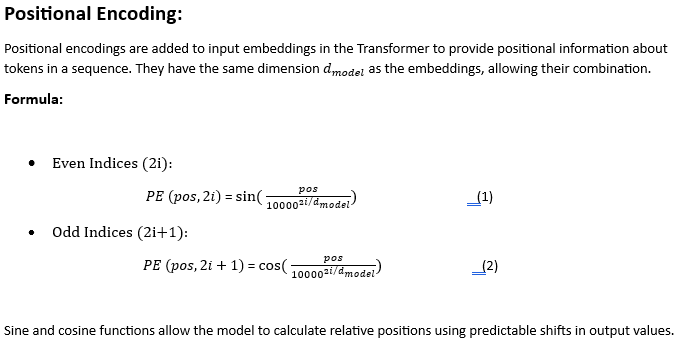

1, (-math.log(10000.0) / d_model) for numerical instability presented by harvard researchers.

2, self.register_buffer('pe', pe) is using for saving positions in state_dict when we save our learnable parameters we also want to save positions, but the the purpose of register buffer is not to optimize pe(positions) when other parameters will be optimized.


In [40]:
# Creating the Positional Encoding
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, seq_len: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model # Dimensionality of the model
        self.seq_len = seq_len # Maximum sequence length
        self.dropout = nn.Dropout(dropout) # Dropout layer to prevent overfitting

        # Creating a positional encoding matrix of shape (seq_len, d_model) filled with zeros
        pe = torch.zeros(seq_len, d_model)

        # Creating a tensor representing positions (0 to seq_len - 1)
        position = torch.arange(0, seq_len, dtype = torch.float).unsqueeze(1) # Transforming 'position' into a 2D tensor['seq_len, 1']

        # Creating the division term for the positional encoding formula
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Apply sine to even indices in pe
        pe[:, 0::2] = torch.sin(position * div_term)
        # Apply cosine to odd indices in pe
        pe[:, 1::2] = torch.cos(position * div_term)

        # Adding an extra dimension at the beginning of pe matrix for batch handling
        pe = pe.unsqueeze(0)

        # Registering 'pe' as buffer. Buffer is a tensor not considered as a model parameter
        self.register_buffer('pe', pe)

    def forward(self,x):
        # Addind positional encoding to the input tensor X
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False)
        return self.dropout(x) # Dropout for regularization


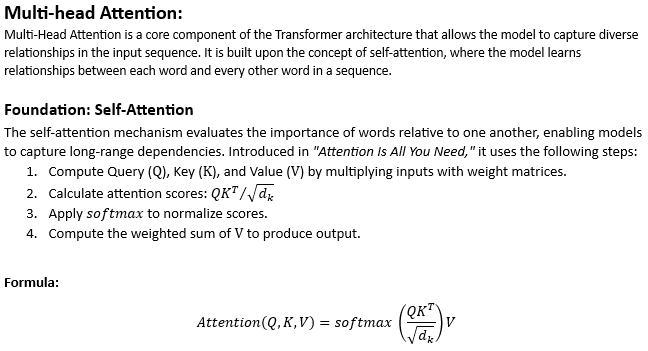

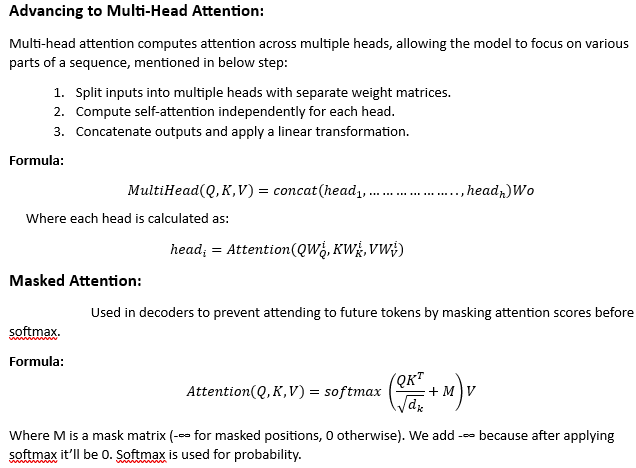

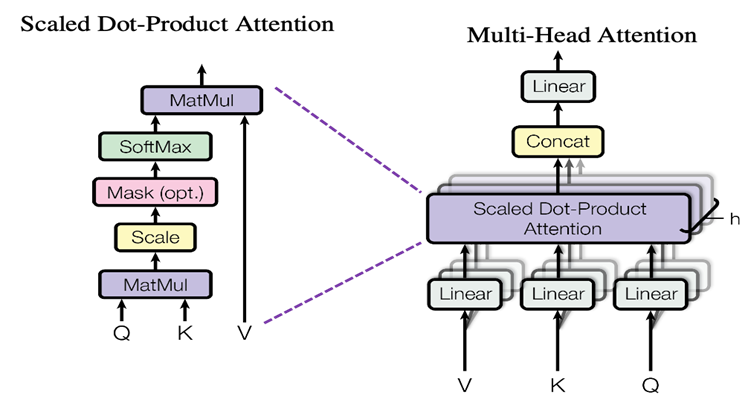

1, masking is for not showing the next token and it should predict the next token by its own e.g the 1st token in 1st row will be 1 and other will be 0 then in 2nd row 1st 2 tokens will be 1 and the rest will be 0.

2, Dropout is used for removing overfitting.

3, @staticmethod known as decorator and used as function within class. If we use this function in our class then we do not need to create instance for that class but when we use the class we can only use name of the class.

In [41]:
# Creating the Multi-Head Attention block
class MultiHeadAttentionBlock(nn.Module):

    def __init__(self, d_model: int, h: int, dropout: float) -> None: # h = number of heads
        super().__init__()
        self.d_model = d_model
        self.h = h

        # We ensure that the dimensions of the model is divisible by the number of heads
        assert d_model % h == 0, 'd_model is not divisible by h'

        # d_k is the dimension of each attention head's key, query, and value vectors
        self.d_k = d_model // h # d_k formula, like in the original "Attention Is All You Need" paper

        # Defining the weight matrices
        self.w_q = nn.Linear(d_model, d_model) # W_q
        self.w_k = nn.Linear(d_model, d_model) # W_k
        self.w_v = nn.Linear(d_model, d_model) # W_v
        self.w_o = nn.Linear(d_model, d_model) # W_o

        self.dropout = nn.Dropout(dropout) # Dropout layer to avoid overfitting

    @staticmethod
    def attention(query, key, value, mask, dropout: nn.Dropout):# mask => When we want certain words to NOT interact with others, we "hide" them

        d_k = query.shape[-1] # The last dimension of query, key, and value

        # We calculate the Attention(Q,K,V) as in the formula in the image above
        attention_scores = (query @ key.transpose(-2,-1)) / math.sqrt(d_k) # @ = Matrix multiplication sign in PyTorch

        # Before applying the softmax, we apply the mask to hide some interactions between words
        if mask is not None: # If a mask IS defined...
            attention_scores.masked_fill_(mask == 0, -1e9) # Replace each value where mask is equal to 0 by -1e9
        attention_scores = attention_scores.softmax(dim = -1) # Applying softmax
        if dropout is not None: # If a dropout IS defined...
            attention_scores = dropout(attention_scores) # We apply dropout to prevent overfitting

        return (attention_scores @ value), attention_scores # Multiply the output matrix by the V matrix, as in the formula

    def forward(self, q, k, v, mask):

        query = self.w_q(q) # Q' matrix
        key = self.w_k(k) # K' matrix
        value = self.w_v(v) # V' matrix

        # Splitting results into smaller matrices for the different heads
        # Splitting embeddings (third dimension) into h parts
        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1,2) # Transpose => bring the head to the second dimension
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1,2) # Transpose => bring the head to the second dimension
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1,2) # Transpose => bring the head to the second dimension

        # Obtaining the output and the attention scores
        x, self.attention_scores = MultiHeadAttentionBlock.attention(query, key, value, mask, self.dropout)

        # Obtaining the H matrix
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)

        return self.w_o(x) # Multiply the H matrix by the weight matrix W_o, resulting in the MH-A matrix

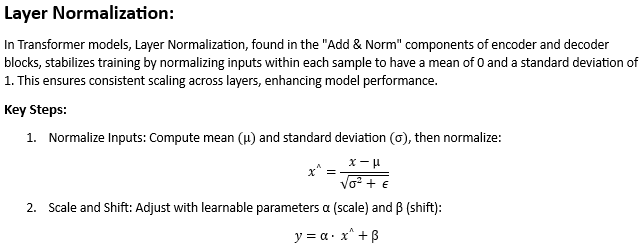

1, we use eps (epsilon) to avoid denominator to become zero. eps is a very small value.

2, Here we calculate mean and standard deviation.

In [42]:
# Creating Layer Normalization
class LayerNormalization(nn.Module):

    def __init__(self, eps: float = 10**-6) -> None: # We define epsilon as 0.000001 to avoid division by zero
        super().__init__()
        self.eps = eps

        # We define alpha as a trainable parameter and initialize it with ones
        self.alpha = nn.Parameter(torch.ones(1)) # One-dimensional tensor that will be used to scale the input data

        # We define bias as a trainable parameter and initialize it with zeros
        self.bias = nn.Parameter(torch.zeros(1)) # One-dimensional tenso that will be added to the input data

    def forward(self, x):
        mean = x.mean(dim = -1, keepdim = True) # Computing the mean of the input data. Keeping the number of dimensions unchanged
        std = x.std(dim = -1, keepdim = True) # Computing the standard deviation of the input data. Keeping the number of dimensions unchanged

        # Returning the normalized input
        return self.alpha * (x-mean) / (std + self.eps) + self.bias


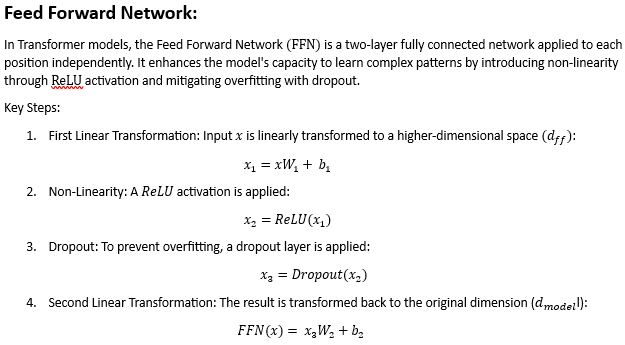

In [43]:
# Creating Feed Forward Layers
class FeedForwardBlock(nn.Module):

    def __init__(self, d_model: int, d_ff: int, dropout: float) -> None:
        super().__init__()
        # First linear transformation
        self.linear_1 = nn.Linear(d_model, d_ff) # W1 & b1
        self.dropout = nn.Dropout(dropout) # Dropout to prevent overfitting
        # Second linear transformation
        self.linear_2 = nn.Linear(d_ff, d_model) # W2 & b2

    def forward(self, x):
        # (Batch, seq_len, d_model) --> (batch, seq_len, d_ff) -->(batch, seq_len, d_model)
        return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))


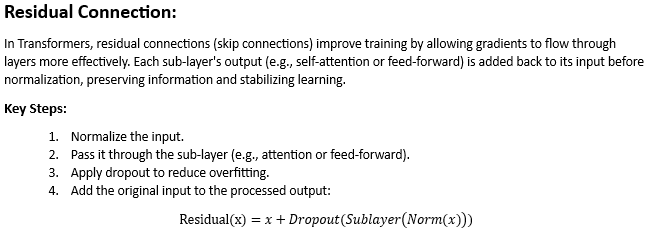

in original paper in this "return x + self.dropout(sublayer(self.norm(x)))" part sublayer is implemented before self.norm. e.g "return x + self.dropout(self.norm(sublayer(x)))" like this. but I have seen many implementation which they implement like above one.

In [44]:
# Building Residual Connection
class ResidualConnection(nn.Module):
    def __init__(self, dropout: float) -> None:
        super().__init__()
        self.dropout = nn.Dropout(dropout) # We use a dropout layer to prevent overfitting
        self.norm = LayerNormalization() # We use a normalization layer

    def forward(self, x, sublayer):
        # We normalize the input and add it to the original input 'x'. This creates the residual connection process.
        return x + self.dropout(sublayer(self.norm(x)))

# **Encoder in Transformers:**

The Encoder processes input data using Self-Attention and Feed Forward layers, with Residual Connections to improve gradient flow and training stability.

**1. Encoder Block**

Each Encoder Block consists of:



*   Multi-Head Self-Attention → Captures contextual relationships.

*   Feed Forward Network → Enhances feature learning.

*   Residual Connections → Helps stable learning.









In [45]:
# Building Encoder Block
class EncoderBlock(nn.Module):

    # This block takes in the MultiHeadAttentionBlock and FeedForwardBlock, as well as the dropout rate for the residual connections
    def __init__(self, self_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        # Storing the self-attention block and feed-forward block
        self.self_attention_block = self_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(2)]) # 2 Residual Connections with dropout

    def forward(self, x, src_mask):
        # Applying the first residual connection with the self-attention block
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, src_mask)) # Three 'x's corresponding to query, key, and value inputs plus source mask

        # Applying the second residual connection with the feed-forward block
        x = self.residual_connections[1](x, self.feed_forward_block)
        return x # Output tensor after applying self-attention and feed-forward layers with residual connections.


**2. Complete Encoder**


*   Self-Attention Weights are calculated and applied.
*   Residual Connection ensures stable learning.


In [46]:
# Building Encoder
# An Encoder can have several Encoder Blocks
class Encoder(nn.Module):

    # The Encoder takes in instances of 'EncoderBlock'
    def __init__(self, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers # Storing the EncoderBlocks
        self.norm = LayerNormalization() # Layer for the normalization of the output of the encoder layers

    def forward(self, x, mask):
        # Iterating over each EncoderBlock stored in self.layers
        for layer in self.layers:
            x = layer(x, mask) # Applying each EncoderBlock to the input tensor 'x'
        return self.norm(x) # Normalizing output

# **Decoder in Transformers**

The Decoder generates the output sequence by using Self-Attention, Cross-Attention, and Feed Forward layers, with Residual Connections ensuring smooth gradient flow and stable training.

**1. Decoder Block**

Each Decoder Block consists of:


*   Self-Attention → Focuses on previously generated words while preventing future word access.
*   Cross-Attention → Aligns decoder outputs with relevant encoder information.

*   Feed Forward Network → Extracts deeper features for better prediction.
*   Residual Connections → Maintains stable training by improving gradient flow.

In [47]:
# Building Decoder Block
class DecoderBlock(nn.Module):

    # The DecoderBlock takes in two MultiHeadAttentionBlock. One is self-attention, while the other is cross-attention.
    # It also takes in the feed-forward block and the dropout rate
    def __init__(self,  self_attention_block: MultiHeadAttentionBlock, cross_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.cross_attention_block = cross_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(3)]) # List of three Residual Connections with dropout rate

    def forward(self, x, encoder_output, src_mask, tgt_mask):

        # Self-Attention block with query, key, and value plus the target language mask
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, tgt_mask))

        # The Cross-Attention block using two 'encoder_ouput's for key and value plus the source language mask. It also takes in 'x' for Decoder queries
        x = self.residual_connections[1](x, lambda x: self.cross_attention_block(x, encoder_output, encoder_output, src_mask))

        # Feed-forward block with residual connections
        x = self.residual_connections[2](x, self.feed_forward_block)
        return x

**2. Decoder Structure**


*   Multiple Decoder Blocks stacked together.
*   Normalization applied after processing.

*   Outputs are passed to a final Linear + Softmax layer for word prediction.

**Key Function:** The decoder generates meaningful outputs by attending to both previously generated words and encoder outputs using attention mechanisms.

In [48]:
# Building Decoder
# A Decoder can have several Decoder Blocks
class Decoder(nn.Module):

    # The Decoder takes in instances of 'DecoderBlock'
    def __init__(self, layers: nn.ModuleList) -> None:
        super().__init__()

        # Storing the 'DecoderBlock's
        self.layers = layers
        self.norm = LayerNormalization() # Layer to normalize the output

    def forward(self, x, encoder_output, src_mask, tgt_mask):

        # Iterating over each DecoderBlock stored in self.layers
        for layer in self.layers:
            # Applies each DecoderBlock to the input 'x' plus the encoder output and source and target masks
            x = layer(x, encoder_output, src_mask, tgt_mask)
        return self.norm(x) # Returns normalized output


# **Projection Layer in Transformers**

The Projection Layer in the Decoder maps the output of the model to a probability distribution over the vocabulary. It converts the final decoder output into predicted tokens.

**1. Linear Layer**

The Linear Layer projects the output from the decoder’s feature space (with dimension d_model) to the vocabulary space (with size vocab_size).


*   **Input:** The feature vector from the final Decoder Block.
*   **Output:** Raw scores for each vocabulary token.

**2. Log Softmax**

The Log Softmax function is applied to the linear output to turn the scores into a logarithmic probability distribution over all possible tokens in the vocabulary.


**Output:** A probability distribution representing the likelihood of each token in the vocabulary being the next token in the sequence.

**Key Points**
*   Linear Projection → Projects model output to vocabulary space.
*   Log Softmax → Converts raw scores to a probability distribution for word prediction.

In [49]:
# Buiding Linear Layer
class ProjectionLayer(nn.Module):
    def __init__(self, d_model: int, vocab_size: int) -> None: # Model dimension and the size of the output vocabulary
        super().__init__()
        self.proj = nn.Linear(d_model, vocab_size) # Linear layer for projecting the feature space of 'd_model' to the output space of 'vocab_size'
    def forward(self, x):
        return torch.log_softmax(self.proj(x), dim = -1) # Applying the log Softmax function to the output

# **Building the Transformer Architecture**

The Transformer model combines the encoder, decoder, and other key components to perform sequence-to-sequence tasks such as translation. Here's how the different parts come together:

**1. Initialization of the Components**

In the Transformer class, we initialize the following components:


*   **Encoder:** Processes the input sequence using self-attention and feed-forward layers

*   **Decoder:** Generates the output sequence using cross-attention, self-attention, and feed-forward layers.
*   **Input Embeddings:** Transforms input tokens into dense vector representations for both the source and target languages.
*   **Positional Encoding:** Adds positional information to the input embeddings since the model does not inherently understand the order of tokens.
*   **Projection Layer:** Converts the decoder output into a probability distribution for token prediction.

**2. Encoding Process**

The encode function handles the source language input:


*   **Embeddings:** Converts input tokens into dense vectors.

*   **Positional Encoding:** Adds positional information to the embeddings.
*   **Encoder:** The processed source embeddings are passed through the encoder to capture contextual information.

**3. Decoding Process**

The decode function processes the target language input:


*   **Embeddings:** Converts target tokens into dense vectors.


*   **Positional Encoding:** Adds positional information to the target embeddings.
*   **Decoder:** The processed target embeddings, along with the encoder's output and masks, are passed through the decoder to generate the output sequence.

**4. Projection Layer**
The project function applies the Projection Layer to the output of the decoder. The projection layer converts the decoder's output into a probability distribution over the vocabulary using a linear transformation followed by a log-softmax function.

In [50]:
# Creating the Transformer Architecture
class Transformer(nn.Module):

    # This takes in the encoder and decoder, as well the embeddings for the source and target language.
    # It also takes in the Positional Encoding for the source and target language, as well as the projection layer
    def __init__(self, encoder: Encoder, decoder: Decoder, src_embed: InputEmbeddings, tgt_embed: InputEmbeddings, src_pos: PositionalEncoding, tgt_pos: PositionalEncoding, projection_layer: ProjectionLayer) -> None:
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.src_pos = src_pos
        self.tgt_pos = tgt_pos
        self.projection_layer = projection_layer

    # Encoder
    def encode(self, src, src_mask):
        src = self.src_embed(src) # Applying source embeddings to the input source language
        src = self.src_pos(src) # Applying source positional encoding to the source embeddings
        return self.encoder(src, src_mask) # Returning the source embeddings plus a source mask to prevent attention to certain elements

    # Decoder
    def decode(self, encoder_output, src_mask, tgt, tgt_mask):
        tgt = self.tgt_embed(tgt) # Applying target embeddings to the input target language (tgt)
        tgt = self.tgt_pos(tgt) # Applying target positional encoding to the target embeddings

        # Returning the target embeddings, the output of the encoder, and both source and target masks
        # The target mask ensures that the model won't 'see' future elements of the sequence
        return self.decoder(tgt, encoder_output, src_mask, tgt_mask)

    # Applying Projection Layer with the Softmax function to the Decoder output
    def project(self, x):
        return self.projection_layer(x)

# **Building and Initializing the Transformer**

The Transformer model is constructed by combining multiple components, each playing a crucial role in processing input and generating output for sequence-to-sequence tasks like machine translation. Here's how the model is built and initialized:

**1. Initialization of Components**

The build_transformer function initializes several key components:

*   Encoder: Processes the source sequence using self-attention and feed-forward layers.
*   Decoder: Generates the target sequence by using self-attention, cross-attention, and feed-forward layers.
*   Input Embeddings: Converts tokens from the source and target languages into dense vector representations.
*   Positional Encoding: Adds positional information to embeddings, as Transformers do not inherently understand token order.
*   Projection Layer: Maps the decoder's output to the target vocabulary, making it ready for token prediction.

**2. Encoding Process**

The encoding process follows these steps:

*   Embeddings: The source tokens are converted into dense vector representations.
*   Positional Encoding: The embeddings are enriched with positional information.
*   Stacked Encoder Layers: The processed embeddings pass through a stack of encoder blocks (N=6), each containing:  

     *   Multi-head self-attention for contextual understanding.
     *   Feed-forward layers for transformation.

**3. Decoding Process**

The decoding process works as follows:


*   Embeddings: Target tokens are converted into dense vectors.

*   Positional Encoding: The positional information is added to target embeddings.
*   Stacked Decoder Layers: The processed target embeddings pass through a stack of decoder blocks (N=6), each containing:
    *   Self-attention: Captures dependencies within the target sequence.
    *   Cross-attention: Connects the target sequence with the encoded source sequence.
    *   Feed-forward layers: Further transforms the representations.

**4. Projection Layer and Initialization**


*   Projection: The decoder output is passed through a linear layer to project it onto the target vocabulary space.
*   Parameter Initialization: The model parameters are initialized using Xavier initialization to ensure stable learning.

**Final Assembly:**
Once all components are initialized, they are combined into a Transformer model that is ready for training and validation.


(We will set the same parameters as in the original paper, Attention Is All You Need, where dmodel = 512, N = 6, h = 8, dropout rate Pdrop = 0.1, and dff = 2048.)

we initialize the parameters using the Xavier uniform
this is a way to initialize the parameters to make the training faster so they don't don't just start with random values and there are many algorithms to do it I saw many implementations using Xavier so I think it's a quite good start for the model to learn from.

In [51]:
# Building & Initializing Transformer

# Definin function and its parameter, including model dimension, number of encoder and decoder stacks, heads, etc.
def build_transformer(src_vocab_size: int, tgt_vocab_size: int, src_seq_len: int, tgt_seq_len: int, d_model: int = 512, N: int = 6, h: int = 8, dropout: float = 0.1, d_ff: int = 2048) -> Transformer:

    # Creating Embedding layers
    src_embed = InputEmbeddings(d_model, src_vocab_size) # Source language (Source Vocabulary to 512-dimensional vectors)
    tgt_embed = InputEmbeddings(d_model, tgt_vocab_size) # Target language (Target Vocabulary to 512-dimensional vectors)

    # Creating Positional Encoding layers
    src_pos = PositionalEncoding(d_model, src_seq_len, dropout) # Positional encoding for the source language embeddings
    tgt_pos = PositionalEncoding(d_model, tgt_seq_len, dropout) # Positional encoding for the target language embeddings

    # Creating EncoderBlocks
    encoder_blocks = [] # Initial list of empty EncoderBlocks
    for _ in range(N): # Iterating 'N' times to create 'N' EncoderBlocks (N = 6)
        encoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout) # Self-Attention
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout) # FeedForward

        # Combine layers into an EncoderBlock
        encoder_block = EncoderBlock(encoder_self_attention_block, feed_forward_block, dropout)
        encoder_blocks.append(encoder_block) # Appending EncoderBlock to the list of EncoderBlocks

    # Creating DecoderBlocks
    decoder_blocks = [] # Initial list of empty DecoderBlocks
    for _ in range(N): # Iterating 'N' times to create 'N' DecoderBlocks (N = 6)
        decoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout) # Self-Attention
        decoder_cross_attention_block = MultiHeadAttentionBlock(d_model, h, dropout) # Cross-Attention
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout) # FeedForward

        # Combining layers into a DecoderBlock
        decoder_block = DecoderBlock(decoder_self_attention_block, decoder_cross_attention_block, feed_forward_block, dropout)
        decoder_blocks.append(decoder_block) # Appending DecoderBlock to the list of DecoderBlocks

    # Creating the Encoder and Decoder by using the EncoderBlocks and DecoderBlocks lists
    encoder = Encoder(nn.ModuleList(encoder_blocks))
    decoder = Decoder(nn.ModuleList(decoder_blocks))

    # Creating projection layer
    projection_layer = ProjectionLayer(d_model, tgt_vocab_size) # Map the output of Decoder to the Target Vocabulary Space

    # Creating the transformer by combining everything above
    transformer = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection_layer)

    # Initialize the parameters
    for p in transformer.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

    return transformer # Assembled and initialized Transformer. Ready to be trained and validated!

# **Tokenization in the Transformer Model**

Tokenization converts raw text into numerical input for the Transformer. We use word-level tokenization, where each word is mapped to a unique integer ID. Special tokens help structure sequences:


*   [UNK] → Unknown words
*   [PAD] → Padding for uniform sequence length
*   [SOS] → Start of Sentence
*   [EOS] → End of Sentence

**Training the Tokenizer**

The build_tokenizer function:

*   Loads an existing tokenizer or trains a new one if unavailable.
*   Uses a whitespace-based pre-tokenizer and a WordLevelTrainer with special tokens.
*   Trains on dataset sentences and saves the tokenizer.

**Tokenized Input for the Transformer**

*   Encoder Input: Tokenized source sentence, converted into embeddings.
*   Decoder Input: Tokenized target sentence with [SOS] and [EOS].

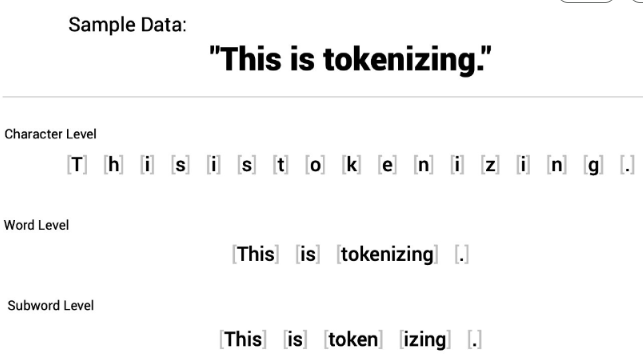

In [52]:
# Defining Tokenizer
def build_tokenizer(config, ds, lang):

    # Crating a file path for the tokenizer
    tokenizer_path = Path(config['tokenizer_file'].format(lang))

    # Checking if Tokenizer already exists
    if not Path.exists(tokenizer_path):

        # If it doesn't exist, we create a new one
        tokenizer = Tokenizer(WordLevel(unk_token = '[UNK]')) # Initializing a new world-level tokenizer
        tokenizer.pre_tokenizer = Whitespace() # We will split the text into tokens based on whitespace

        # Creating a trainer for the new tokenizer
        trainer = WordLevelTrainer(special_tokens = ["[UNK]", "[PAD]",
                                                     "[SOS]", "[EOS]"], min_frequency = 2) # Defining Word Level strategy and special tokens

        # Training new tokenizer on sentences from the dataset and language specified
        tokenizer.train_from_iterator(get_all_sentences(ds, lang), trainer = trainer)
        tokenizer.save(str(tokenizer_path)) # Saving trained tokenizer to the file path specified at the beginning of the function
    else:
        tokenizer = Tokenizer.from_file(str(tokenizer_path)) # If the tokenizer already exist, we load it
    return tokenizer # Returns the loaded tokenizer or the trained tokenizer


# **Load Dataset**

We use the OpusBooks dataset from Hugging Face, which contains sentence pairs in multiple languages. Initially, I tested English-to-Portuguese translation but found it insufficient due to only 1.4k examples. English-French had 127k examples but required too much training time. Therefore, I selected the English-Italian pair for a balance between performance and training time.

**1. Extracting Sentences**

The get_all_sentences function iterates through the dataset to extract sentences for the selected language pair.

In [53]:
# Iterating through dataset to extract the original sentence and its translation
def get_all_sentences(ds, lang):
    for pair in ds:
        yield pair['translation'][lang]


**2. Preparing the Dataset**

The get_ds function loads and tokenizes the dataset, splits it into training (90%) and validation (10%), and creates DataLoaders for batch processing.

In [54]:
def get_ds(config):

    # Loading the train portion of the OpusBooks dataset.
    # The Language pairs will be defined in the 'config' dictionary we will build later
    ds_raw = load_dataset('opus_books', f'{config["lang_src"]}-{config["lang_tgt"]}', split = 'train')

    # Building or loading tokenizer for both the source and target languages
    tokenizer_src = build_tokenizer(config, ds_raw, config['lang_src'])
    tokenizer_tgt = build_tokenizer(config, ds_raw, config['lang_tgt'])

    # Splitting the dataset for training and validation
    train_ds_size = int(0.9 * len(ds_raw)) # 90% for training
    val_ds_size = len(ds_raw) - train_ds_size # 10% for validation
    train_ds_raw, val_ds_raw = random_split(ds_raw, [train_ds_size, val_ds_size]) # Randomly splitting the dataset

    # Processing data with the BilingualDataset class, which we will define below
    train_ds = BilingualDataset(train_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], config['seq_len'])
    val_ds = BilingualDataset(val_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], config['seq_len'])

    # Iterating over the entire dataset and printing the maximum length found in the sentences of both the source and target languages
    max_len_src = 0
    max_len_tgt = 0
    for pair in ds_raw:
        src_ids = tokenizer_src.encode(pair['translation'][config['lang_src']]).ids
        tgt_ids = tokenizer_src.encode(pair['translation'][config['lang_tgt']]).ids
        max_len_src = max(max_len_src, len(src_ids))
        max_len_tgt = max(max_len_tgt, len(tgt_ids))

    print(f'Max length of source sentence: {max_len_src}')
    print(f'Max length of target sentence: {max_len_tgt}')

    # Creating dataloaders for the training and validadion sets
    # Dataloaders are used to iterate over the dataset in batches during training and validation
    train_dataloader = DataLoader(train_ds, batch_size = config['batch_size'], shuffle = True) # Batch size will be defined in the config dictionary
    val_dataloader = DataLoader(val_ds, batch_size = 1, shuffle = True)

    return train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt # Returning the DataLoader objects and tokenizers


**3. Causal Masking**

The casual_mask function prevents the decoder from accessing future tokens during training.

In [55]:
def casual_mask(size):
        # Creating a square matrix of dimensions 'size x size' filled with ones
        mask = torch.triu(torch.ones(1, size, size), diagonal = 1).type(torch.int)
        return mask == 0

**Bilingual Dataset Class**

The BilingualDataset class tokenizes input text, ensures proper sequence length, and adds special tokens ([SOS], [EOS], [PAD]).

In [56]:
class BilingualDataset(Dataset):

    # This takes in the dataset contaning sentence pairs, the tokenizers for target and source languages, and the strings of source and target languages
    # 'seq_len' defines the sequence length for both languages
    def __init__(self, ds, tokenizer_src, tokenizer_tgt, src_lang, tgt_lang, seq_len) -> None:
        super().__init__()

        self.seq_len = seq_len
        self.ds = ds
        self.tokenizer_src = tokenizer_src
        self.tokenizer_tgt = tokenizer_tgt
        self.src_lang = src_lang
        self.tgt_lang = tgt_lang

        # Defining special tokens by using the target language tokenizer
        self.sos_token = torch.tensor([tokenizer_tgt.token_to_id("[SOS]")], dtype=torch.int64)
        self.eos_token = torch.tensor([tokenizer_tgt.token_to_id("[EOS]")], dtype=torch.int64)
        self.pad_token = torch.tensor([tokenizer_tgt.token_to_id("[PAD]")], dtype=torch.int64)


    # Total number of instances in the dataset (some pairs are larger than others)
    def __len__(self):
        return len(self.ds)

    # Using the index to retrive source and target texts
    def __getitem__(self, index: Any) -> Any:
        src_target_pair = self.ds[index]
        src_text = src_target_pair['translation'][self.src_lang]
        tgt_text = src_target_pair['translation'][self.tgt_lang]

        # Tokenizing source and target texts
        enc_input_tokens = self.tokenizer_src.encode(src_text).ids
        dec_input_tokens = self.tokenizer_tgt.encode(tgt_text).ids

        # Computing how many padding tokens need to be added to the tokenized texts
        # Source tokens
        enc_num_padding_tokens = self.seq_len - len(enc_input_tokens) - 2 # Subtracting the two '[EOS]' and '[SOS]' special tokens
        # Target tokens
        dec_num_padding_tokens = self.seq_len - len(dec_input_tokens) - 1 # Subtracting the '[SOS]' special token

        # If the texts exceed the 'seq_len' allowed, it will raise an error. This means that one of the sentences in the pair is too long to be processed
        # given the current sequence length limit (this will be defined in the config dictionary below)
        if enc_num_padding_tokens < 0 or dec_num_padding_tokens < 0:
            raise ValueError('Sentence is too long')

        # Building the encoder input tensor by combining several elements
        encoder_input = torch.cat(
            [
            self.sos_token, # inserting the '[SOS]' token
            torch.tensor(enc_input_tokens, dtype = torch.int64), # Inserting the tokenized source text
            self.eos_token, # Inserting the '[EOS]' token
            torch.tensor([self.pad_token] * enc_num_padding_tokens, dtype = torch.int64) # Addind padding tokens
            ]
        )

        # Building the decoder input tensor by combining several elements
        decoder_input = torch.cat(
            [
                self.sos_token, # inserting the '[SOS]' token
                torch.tensor(dec_input_tokens, dtype = torch.int64), # Inserting the tokenized target text
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype = torch.int64) # Addind padding tokens
            ]

        )

        # Creating a label tensor, the expected output for training the model
        label = torch.cat(
            [
                torch.tensor(dec_input_tokens, dtype = torch.int64), # Inserting the tokenized target text
                self.eos_token, # Inserting the '[EOS]' token
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype = torch.int64) # Adding padding tokens

            ]
        )

        # Ensuring that the length of each tensor above is equal to the defined 'seq_len'
        assert encoder_input.size(0) == self.seq_len
        assert decoder_input.size(0) == self.seq_len
        assert label.size(0) == self.seq_len

        return {
            'encoder_input': encoder_input,
            'decoder_input': decoder_input,
            'encoder_mask': (encoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int(),
            'decoder_mask': (decoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int() & casual_mask(decoder_input.size(0)),
            'label': label,
            'src_text': src_text,
            'tgt_text': tgt_text
        }

# **Validation Loop**

The validation loop is crucial for evaluating the model's performance in translating sentences it has not encountered during training. We define two key functions for this process:

1.   **greedy_decode:** This function generates the model's output by selecting the most probable next token at each step.

In [57]:
# Define function to obtain the most probable next token
def greedy_decode(model, source, source_mask, tokenizer_src, tokenizer_tgt, max_len, device):
    # Retrieving the indices from the start and end of sequences of the target tokens
    sos_idx = tokenizer_tgt.token_to_id('[SOS]')
    eos_idx = tokenizer_tgt.token_to_id('[EOS]')

    # Computing the output of the encoder for the source sequence
    encoder_output = model.encode(source, source_mask)
    # Initializing the decoder input with the Start of Sentence token
    decoder_input = torch.empty(1,1).fill_(sos_idx).type_as(source).to(device)

    # Looping until the 'max_len', maximum length, is reached
    while True:
        if decoder_input.size(1) == max_len:
            break

        # Building a mask for the decoder input
        decoder_mask = casual_mask(decoder_input.size(1)).type_as(source_mask).to(device)

        # Calculating the output of the decoder
        out = model.decode(encoder_output, source_mask, decoder_input, decoder_mask)

        # Applying the projection layer to get the probabilities for the next token
        prob = model.project(out[:, -1])

        # Selecting token with the highest probability
        _, next_word = torch.max(prob, dim=1)
        decoder_input = torch.cat([decoder_input, torch.empty(1,1). type_as(source).fill_(next_word.item()).to(device)], dim=1)

        # If the next token is an End of Sentence token, we finish the loop
        if next_word == eos_idx:
            break

    return decoder_input.squeeze(0) # Sequence of tokens generated by the decoder

2.  **run_validation:** This function runs the validation process, where it decodes the model's predictions and compares them with the reference translations.

In [58]:
# Defining function to evaluate the model on the validation dataset
# num_examples = 2, two examples per run
def run_validation(model, validation_ds, tokenizer_src, tokenizer_tgt, max_len, device, print_msg, global_state, writer, num_examples=2):
    model.eval() # Setting model to evaluation mode
    count = 0 # Initializing counter to keep track of how many examples have been processed

    console_width = 80 # Fixed witdh for printed messages

    # Creating evaluation loop
    with torch.no_grad(): # Ensuring that no gradients are computed during this process
        for batch in validation_ds:
            count += 1
            encoder_input = batch['encoder_input'].to(device)
            encoder_mask = batch['encoder_mask'].to(device)

            # Ensuring that the batch_size of the validation set is 1
            assert encoder_input.size(0) ==  1, 'Batch size must be 1 for validation.'

            # Applying the 'greedy_decode' function to get the model's output for the source text of the input batch
            model_out = greedy_decode(model, encoder_input, encoder_mask, tokenizer_src, tokenizer_tgt, max_len, device)

            # Retrieving source and target texts from the batch
            source_text = batch['src_text'][0]
            target_text = batch['tgt_text'][0] # True translation
            model_out_text = tokenizer_tgt.decode(model_out.detach().cpu().numpy()) # Decoded, human-readable model output

            # Printing results
            print_msg('-'*console_width)
            print_msg(f'SOURCE: {source_text}')
            print_msg(f'TARGET: {target_text}')
            print_msg(f'PREDICTED: {model_out_text}')

            # After two examples, we break the loop
            if count == num_examples:
                break


# **Training Loop**

We are now ready to train our Transformer model on the OpusBook dataset for the English-to-Italian translation task.

**1. Model Initialization**

First, we define the **get_model** function to initialize the Transformer model using the previously defined **build_transformer** function. This function takes the configuration dictionary (**config**) and the vocabulary sizes of the source and target languages as input.

In [59]:
# We pass as parameters the config dictionary, the length of the vocabylary of the source language and the target language
def get_model(config, vocab_src_len, vocab_tgt_len):

    # Loading model using the 'build_transformer' function.
    # We will use the lengths of the source language and target language vocabularies, the 'seq_len', and the dimensionality of the embeddings
    model = build_transformer(vocab_src_len, vocab_tgt_len, config['seq_len'], config['seq_len'], config['d_model'])
    return model


**2. Configuration Setup**

The get_config function defines key training parameters, including:

**batch_size:** Number of samples per training batch.

**num_epochs:** Total training iterations over the dataset.

**lr:** Learning rate for the optimizer.

**seq_len:** Maximum sequence length for inputs.

**d_model:** Dimensionality of embeddings.

**lang_src and lang_tgt:** Source and target languages.

**model_folder:** Directory for saving model checkpoints.
python.

In [60]:
# Define settings for building and training the transformer model
def get_config():
    return{
        'batch_size': 8,
        'num_epochs': 5,
        'lr': 10**-4,
        'seq_len': 350,
        'd_model': 512, # Dimensions of the embeddings in the Transformer. 512 like in the "Attention Is All You Need" paper.
        'lang_src': 'en',
        'lang_tgt': 'it',
        'model_folder': 'weights',
        'model_basename': 'tmodel_',
        'preload': None,
        'tokenizer_file': 'tokenizer_{0}.json',
        'experiment_name': 'runs/tmodel'
    }


Additionally, the **get_weights_file_path** function constructs the path for saving or loading model checkpoints based on the current epoch.

In [61]:
# Function to construct the path for saving and retrieving model weights
def get_weights_file_path(config, epoch: str):
    model_folder = config['model_folder'] # Extracting model folder from the config
    model_basename = config['model_basename'] # Extracting the base name for model files
    model_filename = f"{model_basename}{epoch}.pt" # Building filename
    return str(Path('.')/ model_folder/ model_filename) # Combining current directory, the model folder, and the model filename

**3. Training Process**

The train_model function sets up and executes the training loop. It:

*   Moves the model to GPU (if available) for faster training.
*   Loads the dataset and tokenizers using get_ds().
*   Initializes the Adam optimizer with a small epsilon value.
*   Configures the CrossEntropyLoss function, ignoring padding tokens.
*   Iterates through training batches to:

     *   Compute forward passes.
     *   Calculate loss.

*   Perform backpropagation and update weights.
*   Log loss values using TensorBoard.
*   Runs validation after each epoch.
*   Saves model checkpoints.



In [62]:
def train_model(config):
    # Setting up device to run on GPU to train faster
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device {device}")

    # Creating model directory to store weights
    Path(config['model_folder']).mkdir(parents=True, exist_ok=True)

    # Retrieving dataloaders and tokenizers for source and target languages using the 'get_ds' function
    train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt = get_ds(config)

    # Initializing model on the GPU using the 'get_model' function
    model = get_model(config,tokenizer_src.get_vocab_size(), tokenizer_tgt.get_vocab_size()).to(device)

    # Tensorboard
    writer = SummaryWriter(config['experiment_name'])

    # Setting up the Adam optimizer with the specified learning rate from the '
    # config' dictionary plus an epsilon value
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], eps = 1e-9)

    # Initializing epoch and global step variables
    initial_epoch = 0
    global_step = 0

    # Checking if there is a pre-trained model to load
    # If true, loads it
    if config['preload']:
        model_filename = get_weights_file_path(config, config['preload'])
        print(f'Preloading model {model_filename}')
        state = torch.load(model_filename) # Loading model

        # Sets epoch to the saved in the state plus one, to resume from where it stopped
        initial_epoch = state['epoch'] + 1
        # Loading the optimizer state from the saved model
        optimizer.load_state_dict(state['optimizer_state_dict'])
        # Loading the global step state from the saved model
        global_step = state['global_step']

    # Initializing CrossEntropyLoss function for training
    # We ignore padding tokens when computing loss, as they are not relevant for the learning process
    # We also apply label_smoothing to prevent overfitting
    loss_fn = nn.CrossEntropyLoss(ignore_index = tokenizer_src.token_to_id('[PAD]'), label_smoothing = 0.1).to(device)

    # Initializing training loop

    # Iterating over each epoch from the 'initial_epoch' variable up to
    # the number of epochs informed in the config
    for epoch in range(initial_epoch, config['num_epochs']):

        # Initializing an iterator over the training dataloader
        # We also use tqdm to display a progress bar
        batch_iterator = tqdm(train_dataloader, desc = f'Processing epoch {epoch:02d}')

        # For each batch...
        for batch in batch_iterator:
            model.train() # Train the model

            # Loading input data and masks onto the GPU
            encoder_input = batch['encoder_input'].to(device)
            decoder_input = batch['decoder_input'].to(device)
            encoder_mask = batch['encoder_mask'].to(device)
            decoder_mask = batch['decoder_mask'].to(device)

            # Running tensors through the Transformer
            encoder_output = model.encode(encoder_input, encoder_mask)
            decoder_output = model.decode(encoder_output, encoder_mask, decoder_input, decoder_mask)
            proj_output = model.project(decoder_output)

            # Loading the target labels onto the GPU
            label = batch['label'].to(device)

            # Computing loss between model's output and true labels
            loss = loss_fn(proj_output.view(-1, tokenizer_tgt.get_vocab_size()), label.view(-1))

            # Updating progress bar
            batch_iterator.set_postfix({f"loss": f"{loss.item():6.3f}"})

            writer.add_scalar('train loss', loss.item(), global_step)
            writer.flush()

            # Performing backpropagation
            loss.backward()

            # Updating parameters based on the gradients
            optimizer.step()

            # Clearing the gradients to prepare for the next batch
            optimizer.zero_grad()

            global_step += 1 # Updating global step count

        # We run the 'run_validation' function at the end of each epoch
        # to evaluate model performance
        run_validation(model, val_dataloader, tokenizer_src, tokenizer_tgt, config['seq_len'], device, lambda msg: batch_iterator.write(msg), global_step, writer)

        # Saving model
        model_filename = get_weights_file_path(config, f'{epoch:02d}')
        # Writting current model state to the 'model_filename'
        torch.save({
            'epoch': epoch, # Current epoch
            'model_state_dict': model.state_dict(),# Current model state
            'optimizer_state_dict': optimizer.state_dict(), # Current optimizer state
            'global_step': global_step # Current global step
        }, model_filename)


**We can now train the model!**

In [63]:
if __name__ == '__main__':
    warnings.filterwarnings('ignore') # Filtering warnings
    config = get_config() # Retrieving config settings
    train_model(config) # Training model with the config arguments

Using device cuda
Max length of source sentence: 309
Max length of target sentence: 274


Processing epoch 00: 100%|██████████| 3638/3638 [24:48<00:00,  2.44it/s, loss=6.067]


--------------------------------------------------------------------------------
SOURCE: 'Mine is a long and a sad tale!' said the Mouse, turning to Alice, and sighing.
TARGET: — La mia storia è lunga e triste e con la coda! — rispose il Topo, sospirando.
PREDICTED: — , — disse , — disse Levin , — disse Levin .
--------------------------------------------------------------------------------
SOURCE: Besides, with this creed, I can so clearly distinguish between the criminal and his crime; I can so sincerely forgive the first while I abhor the last: with this creed revenge never worries my heart, degradation never too deeply disgusts me, injustice never crushes me too low: I live in calm, looking to the end."
TARGET: Con questa fede, faccio una differenza fra il peccatore e il suo peccato; perdono sinceramente al primo e odio il secondo; il desiderio della vendetta non mi opprime il cuore, il vizio non mi disgusta abbastanza per allontanarmi dal colpevole e l'ingiustizia non mi toglie il

Processing epoch 01: 100%|██████████| 3638/3638 [24:47<00:00,  2.45it/s, loss=5.763]


--------------------------------------------------------------------------------
SOURCE: There at any rate the whole people directly expresses its will.'
TARGET: In questo tutto il popolo esprime la propria volontà.
PREDICTED: , come si , , .
--------------------------------------------------------------------------------
SOURCE: 'Kitty, it is getting chilly!
TARGET: — Kitty, fa fresco!
PREDICTED: — Kitty , ecco , ecco , .


Processing epoch 02: 100%|██████████| 3638/3638 [24:46<00:00,  2.45it/s, loss=5.641]


--------------------------------------------------------------------------------
SOURCE: On Vronsky's face, usually so firm and self-possessed she noticed that expression of bewilderment and submission which had so surprised her – an expression like that of an intelligent dog when it feels guilty.
TARGET: E sul viso di Vronskij, sempre così deciso e libero, vedeva quell’espressione di smarrimento e di sottomissione che l’aveva stupita; l’espressione di un cane intelligente che si senta colpevole.
PREDICTED: Il suo viso , Vronskij si sentiva sempre sempre più di lei e di lui , e la sua volta , e la sua volta , che era un di , che era un ’ altra cosa .
--------------------------------------------------------------------------------
SOURCE: Your dog is quicker to recognise his friends than you are, sir; he pricked his ears and wagged his tail when I was at the bottom of the field, and you have your back towards me now."
TARGET: Il vostro cane è più sollecito di voi nel riconoscere gli ami

Processing epoch 03: 100%|██████████| 3638/3638 [24:45<00:00,  2.45it/s, loss=4.725]


--------------------------------------------------------------------------------
SOURCE: So they change back again, and come to the conclusion that the man has given them the wrong set altogether; and over their mutual abuse of this man they become quite friendly and sympathetic.
TARGET: Allora si scambiano di nuovo gli strumenti, e vengono alla conclusione che il padrone della barca ha loro dato due paia di remi di un’altra imbarcazione, e, riversando il loro comune risentimento sul padrone, corroborano la loro amicizia e la loro simpatia.
PREDICTED: E poi , dopo aver preso la fine , e la è la , e la , e la , e li , e li .
--------------------------------------------------------------------------------
SOURCE: When he came nearer he saw, sitting beside Oblonsky, a stout handsome young man wearing a Scotch bonnet with long ribbons streaming behind.
TARGET: Quando si fu accostato alla carrozza, vide, accanto a Stepan Arkad’ic, non già il principe, ma un bel giovane robusto, con un berre

Processing epoch 04: 100%|██████████| 3638/3638 [24:45<00:00,  2.45it/s, loss=4.031]


--------------------------------------------------------------------------------
SOURCE: I tried to reassure her, and to make light of the whole affair.
TARGET: Tentai di rassicurarla, e di trattar tutta la faccenda con leggerezza.
PREDICTED: Mi parve di nuovo e di nuovo il suo posto .
--------------------------------------------------------------------------------
SOURCE: 'Ah, well! there's no time now,' added Koznyshev as the children came running in.
TARGET: — Eh sì, il resto a dopo, non c’è neanche tempo — soggiunse Sergej Ivanovic, vedendo i bambini venir fuori correndo.
PREDICTED: — Ah , non c ’ è tempo , non è tempo — disse Sergej Ivanovic , come si fosse messo in modo .
